<a href="https://colab.research.google.com/github/sellerstx1982/multimodal_damage_identification/blob/Alkhatib/currentcode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from pathlib import Path
from sklearn.metrics import classification_report, balanced_accuracy_score, accuracy_score, classification_report
from PIL import Image, ImageFile
import os
import matplotlib.pyplot as plt
import zipfile

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from transformers import GPT2Tokenizer, TFGPT2LMHeadModel
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Load the data from pkl files
def load_data_from_pkl(pkl_filename):
    with open(pkl_filename, 'rb') as f:
        df = pickle.load(f)
    return df

df = load_data_from_pkl('/content/drive/MyDrive/Colab Notebooks/multimodel/disaster_data (2).pkl')

# Preprocessing

In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True
main_folder = "/content/drive/MyDrive/Colab Notebooks/multimodel"

In [ ]:
# Lists to store the data
images = []
texts = []
labels = []

# Preprocessing function for images
def preprocess_image(image_path):
    try:
        image = Image.open(image_path)
        image = image.resize((250, 250))  # Example size, adjust accordingly
        # image = np.array(image) / 255.0  # Normalize pixel values
        # return np.expand_dims(image, axis=0)  # Add batch dimension
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

# Function to load text from a file
def load_text_file(text_path):
    try:
        with open(text_path, 'r', encoding='utf-8') as file:
            return file.read()
    except Exception as e:
        print(f"Error reading text file {text_path}: {e}")
        return None

In [ ]:
# Iterate over each category subfolder in the main folder
for subfolder in os.listdir(main_folder):
    subfolder_path = os.path.join(main_folder, subfolder)
    if os.path.isdir(subfolder_path):
        # The image and text folders inside each category folder
        image_folder = os.path.join(subfolder_path, 'images')
        text_folder = os.path.join(subfolder_path, 'text')

        # Check if both the image and text folders exist
        if os.path.exists(image_folder) and os.path.exists(text_folder):
            for image_file in os.listdir(image_folder):
                if image_file.endswith(('jpg', 'jpeg', 'png')):
                    image_path = os.path.join(image_folder, image_file)
                    # Construct the corresponding text file name
                    text_file = image_file.rsplit('.', 1)[0] + '.txt'
                    text_path = os.path.join(text_folder, text_file)

                    # Check if the text file exists and load both image and text
                    if os.path.exists(text_path):
                        image = preprocess_image(image_path)
                        if image is not None:
                            text = load_text_file(text_path)
                            if text is not None:
                                # Extract the label by splitting at the underscore and taking the first part
                                label = image_file.split('_', 1)[0]
                                images.append(image)
                                texts.append(text)
                                labels.append(label)  # Append the prefix before the first underscore as label


In [ ]:
# images = np.array([np.array(image) for image in images])
type(images)

list

In [ ]:
print(len(images))
print(len(texts))
print(len(labels))

5831
5831
5831


In [ ]:
df = pd.DataFrame({'image': images, 'text': texts, 'label': labels})
df.head()

,image,text,label
0,"[[[[0.85098039 0.74117647 0.62352941], [0.8588...",yikes #buildingcollapse #eastharlem #trainview,buildingcollapse
1,"[[[[0.69411765 0.63921569 0.72941176], [0.6823...",Goil filling station on fire\n#hmm \n#accrafloods,accrafloods
2,"[[[[0. 0. 0.11764706], [0. ...",****66-55-1406** 5th alarm #fdny#firefighters#...,buildingcollapse
3,"[[[[0.34509804 0.22352941 0.34901961], [0.3529...",****66-55-1406** 5th alarm #FDNY#firefighters#...,buildingcollapse
4,"[[[[0. 0. 0.10980392], [0. ...",Does anyone who lives around 635 & Centerville...,buildingcollapse


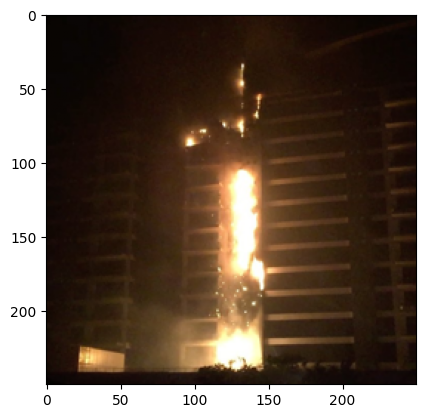

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image

# Assuming 'df' is your DataFrame
specific_row = df.iloc[10]  # Select the first row as an example

# Access the image data from the selected row
image_data = specific_row['image']

# Display the image if it's in a recognizable format
if isinstance(image_data, np.ndarray):
    # Squeeze the image data to remove the extra dimension
    image_data = np.squeeze(image_data)  # This removes dimensions of size 1
    plt.imshow(image_data)
    plt.show()
elif isinstance(image_data, Image.Image):
    image_data.show()
else:
    print("Image data is not in a recognizable format.")

In [ ]:
df['label_2'] = df['label'].replace({'destruction': 'destruction',
                                   'drought': 'drought',
                                   'buildingcollapse': 'earthquake',
                                   'destroyedbuilding': 'earthquake',
                                   'earthquake': 'earthquake',
                                   'earthquakenepal': 'earthquake',
                                   'buildingfire': 'fire',
                                   'forestfire': 'fire',
                                   'forrestfire': 'fire',
                                   'wildfires': 'fire',
                                   'accrafloods': 'flood',
                                   'floodwater': 'flood',
                                   'hurricaneharvey': 'hurricane',
                                   'hurricaneirma': 'hurricane',
                                   'hurricanematthew': 'hurricane',
                                   'hurricanesandy': 'hurricane',
                                   'sandydamage': 'hurricane',
                                   'treefalling': 'hurricane',
                                   'treesfalling': 'hurricane',
                                   'windstorm': 'hurricane',
                                   'landslide': 'landslide',
                                   'disaster': 'naturaldisaster',
                                   'disasters': 'naturaldisaster',
                                   'naturaldamage': 'naturaldisaster',
                                   'naturaldisaster': 'naturaldisaster',
                                   'ad': 'non-damage',
                                   'building': 'non-damage',
                                   'cars': 'non-damage',
                                   'food': 'non-damage',
                                   'nature': 'non-damage',
                                   'terrorattack': 'war',
                                   'isiscrimes': 'war',
                                   'yemencrisis': 'war',
                                   'suicidebombing': 'war',
                                   'victimsofwar': 'war',
                                   'war': 'war',
                                   'syriawarcrimes': 'war',
                                   'warsyria': 'war',
                                   'yemencrisis': 'war',
                                   'wreckedcar': 'wreckedcar',
                                   })

In [ ]:
df['label_2'].value_counts()

,count
label_2,
non-damage,2957
hurricane,592
earthquake,542
wreckedcar,400
war,322
flood,277
fire,262
naturaldisaster,231
drought,102


In [ ]:
df['label_3'] = df['label'].replace({'destruction': 'damage',
                                   'drought': 'damage',
                                   'buildingcollapse': 'damage',
                                   'destroyedbuilding': 'damage',
                                   'earthquake': 'damage',
                                   'earthquakenepal': 'damage',
                                   'buildingfire': 'damage',
                                   'forestfire': 'damage',
                                   'forrestfire': 'damage',
                                   'wildfires': 'damage',
                                   'accrafloods': 'damage',
                                   'floodwater': 'damage',
                                   'hurricaneharvey': 'damage',
                                   'hurricaneirma': 'damage',
                                   'hurricanematthew': 'damage',
                                   'hurricanesandy': 'damage',
                                   'sandydamage': 'damage',
                                   'treefalling': 'damage',
                                   'treesfalling': 'damage',
                                   'windstorm': 'damage',
                                   'landslide': 'damage',
                                   'disaster': 'damage',
                                   'disasters': 'damage',
                                   'naturaldamage': 'damage',
                                   'naturaldisaster': 'damage',
                                   'ad': 'non-damage',
                                   'building': 'non-damage',
                                   'cars': 'non-damage',
                                   'food': 'non-damage',
                                   'nature': 'non-damage',
                                   'terrorattack': 'damage',
                                   'isiscrimes': 'damage',
                                   'yemencrisis': 'damage',
                                   'suicidebombing': 'damage',
                                   'victimsofwar': 'damage',
                                   'war': 'damage',
                                   'syriawarcrimes': 'damage',
                                   'warsyria': 'damage',
                                   'yemencrisis': 'damage',
                                   'wreckedcar': 'damage',
                                   })

In [ ]:
df['label_3'].value_counts()

,count
label_3,
non-damage,2957
damage,2874


In [ ]:
df.head()

,image,text,label,label_2,label_3
0,"[[[[0.85098039 0.74117647 0.62352941], [0.8588...",yikes #buildingcollapse #eastharlem #trainview,buildingcollapse,earthquake,damage
1,"[[[[0.69411765 0.63921569 0.72941176], [0.6823...",Goil filling station on fire\n#hmm \n#accrafloods,accrafloods,flood,damage
2,"[[[[0. 0. 0.11764706], [0. ...",****66-55-1406** 5th alarm #fdny#firefighters#...,buildingcollapse,earthquake,damage
3,"[[[[0.34509804 0.22352941 0.34901961], [0.3529...",****66-55-1406** 5th alarm #FDNY#firefighters#...,buildingcollapse,earthquake,damage
4,"[[[[0. 0. 0.10980392], [0. ...",Does anyone who lives around 635 & Centerville...,buildingcollapse,earthquake,damage


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5831 entries, 0 to 5830
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   image    5831 non-null   object
 1   text     5831 non-null   object
 2   label    5831 non-null   object
 3   label_2  5831 non-null   object
 4   label_3  5831 non-null   object
dtypes: object(5)
memory usage: 227.9+ KB


In [ ]:
sample_df = df.sample(n=1000, random_state=42)
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 4436 to 4841
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   image    1000 non-null   object
 1   text     1000 non-null   object
 2   label    1000 non-null   object
 3   label_2  1000 non-null   object
 4   label_3  1000 non-null   object
dtypes: object(5)
memory usage: 46.9+ KB


In [ ]:
sample_df['label_3'].value_counts()

,count
label_3,
non-damage,503
damage,497


In [ ]:
df['image']

,image
0,"[[[[0.85098039 0.74117647 0.62352941], [0.8588..."
1,"[[[[0.69411765 0.63921569 0.72941176], [0.6823..."
2,"[[[[0. 0. 0.11764706], [0. ..."
3,"[[[[0.34509804 0.22352941 0.34901961], [0.3529..."
4,"[[[[0. 0. 0.10980392], [0. ..."
...,...
5826,"[[[[0.96078431 0.97254902 0.92941176], [0.8901..."
5827,"[[[[0.5372549 0.49411765 0.47058824], [0.5529..."
5828,"[[[[0.41960784 0.42352941 0.4 ], [0.4392..."
5829,"[[[[0.29411765 0.30196078 0.25098039], [0.2941..."


In [ ]:
 import pickle
# Save the data to pkl files
 with open('disaster_data.pkl', 'wb') as f:
     pickle.dump(sample_df, f)


In [ ]:
print(len(images))
print(len(texts))
print(len(labels))

5831
5831
5831


Function for creating DataFrame with label

# Model Ideas

In [ ]:
X_image = sample_df['image']
X_text = sample_df['text']
y = sample_df['label_3']

In [ ]:
X_image = np.array(np.array(X_image))

In [ ]:
X_image = [np.array(img).astype('float32') for img in X_image]

In [ ]:
X_image.iloc[0].shape

(1, 250, 250, 3)

In [ ]:
type(X_image.iloc[0])

numpy.ndarray

In [ ]:
X_image.shape

(1000,)

In [ ]:
y.shape

(1000,)

In [ ]:
X_train_image, X_test_image, X_train_text, X_test_text, y_train, y_test = train_test_split(X_image, X_text, y, test_size=0.2, random_state=42)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
model = Sequential()
# Add convolutional layers
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(250, 250, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
# Add fully connected layers
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))  # Optional dropout for regularization
# Output layer (assuming classification)
model.add(Dense(2, activation='softmax'))  # Use 'sigmoid' for binary classification
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 248, 248, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 124, 124, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 122, 122, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 61, 61, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 119072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │       7,620,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,625,890 (29.09 MB)

 Trainable params: 7,625,890 (29.09 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train_image, y_train, epochs=10, batch_size=32)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type numpy.ndarray).

In [ ]:
import numpy as np

# Before fitting the model, ensure y_train is a 1D numerical array:
y_train = y_train.ravel()  # Flatten if it's multi-dimensional
y_train = y_train.astype(np.float32)  # Ensure correct data type

# Now try fitting the model again:
history = model.fit(X_train_image, y_train, epochs=10, batch_size=32)

<ipython-input-84-414940910858>:4: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_train = y_train.ravel()  # Flatten if it's multi-dimensional


ValueError: could not convert string to float: 'non-damage'

In [ ]:
# Assuming `images` is a numpy array of image data
# Assuming `texts` is a list of raw text corresponding to the images

# Tokenize and pad the text data
# tokenizer = Tokenizer(num_words=10000)  # Adjust vocabulary size as needed
# tokenizer.fit_on_texts(texts)
# sequences = tokenizer.texts_to_sequences(texts)
# max_sequence_length = 100  # Define max sequence length
# padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

# OR

# Using GPT-2 Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Add a padding token to the tokenizer
tokenizer.pad_token = tokenizer.eos_token

def tokenize_texts(texts):
    return tokenizer(texts, return_tensors='tf', padding=True, truncation=True, clean_up_tokenization_spaces=Fa

# Tokenize the text data
tokenized_texts = tokenize_texts(texts)

# Example disaster reports (this could be loaded from your dataset)
sample_reports = ["Flood in Texas causes widespread damage.",
                  "Earthquake in Japan leads to massive destruction."]
tokenized_reports = tokenize_texts(sample_reports)

# Assuming `labels` is a numpy array containing the target labels for the task (e.g., 0 and 1 for binary classification)


In [ ]:
# Split the data into training and test sets
image_train, image_test, text_train, text_test, y_train, y_test = train_test_split(
    images, padded_sequences, labels, test_size=0.2, random_state=42)

print(f"Training set: {image_train.shape}, {text_train.shape}, {y_train.shape}")
print(f"Test set: {image_test.shape}, {text_test.shape}, {y_test.shape}")

In [ ]:
def create_lstm_model(image_feature_size, vocab_size, seq_length):
    image_input = layers.Input(shape=(image_feature_size,))
    text_input = layers.Input(shape=(seq_length,))

    # Combine Image and Text features
    x = layers.Concatenate()([image_input, text_input])
    x = layers.Embedding(vocab_size, 256)(x)
    x = layers.LSTM(256, return_sequences=True)(x)
    x = layers.Dense(vocab_size, activation='softmax')(x)

    model = models.Model(inputs=[image_input, text_input], outputs=x)
    return model

vocab_size = len(tokenizer)  # GPT tokenizer vocab size
seq_length = tokenized_reports['input_ids'].shape[1]  # Max sequence length
lstm_model = create_lstm_model(256, vocab_size, seq_length)

lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
gpt2_model = TFGPT2LMHeadModel.from_pretrained('gpt2')

# Fine-tune GPT-2 model
def fine_tune_gpt2(image_features, texts, tokenizer):
    inputs = tokenizer(texts, return_tensors="tf", padding=True, truncation=True)
    outputs = gpt2_model(inputs['input_ids'], labels=inputs['input_ids'])
    loss = outputs.loss
    logits = outputs.logits

    # Train your model on this loss
    return loss

# Example training loop
for epoch in range(10):
    loss = fine_tune_gpt2(image_features, sample_reports, tokenizer)
    print(f"Epoch {epoch+1}, Loss: {loss}")


In [ ]:
# Save the CNN + LSTM model or GPT-2 based model
lstm_model.save("disaster_report_model.h5")

# For GPT-2 (Hugging Face)
gpt2_model.save_pretrained("disaster_gpt2_model")
tokenizer.save_pretrained("disaster_gpt2_model_tokenizer")


# Creating Web Application

In [ ]:
from flask import Flask, request, jsonify
import tensorflow as tf
from transformers import GPT2Tokenizer, TFGPT2LMHeadModel
from PIL import Image
import numpy as np

# Load the saved LSTM or GPT model
lstm_model = tf.keras.models.load_model('disaster_report_model.h5')

# If using GPT-2
gpt2_model = TFGPT2LMHeadModel.from_pretrained('disaster_gpt2_model')
tokenizer = GPT2Tokenizer.from_pretrained('disaster_gpt2_model_tokenizer')

app = Flask(__name__)

# Image preprocessing function
def preprocess_image(image, target_size=(224, 224)):
    image = Image.open(image)
    image = image.resize(target_size)
    image = np.array(image) / 255.0
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Report generation endpoint
@app.route('/generate_report', methods=['POST'])
def generate_report():
    file = request.files['image']

    # Preprocess the input image
    image = preprocess_image(file)

    # Extract features from the image using CNN
    image_features = lstm_model.predict(image)  # You may want to extract features only

    # Use the LSTM or GPT model to generate a report
    # If LSTM:
    # generated_report = lstm_model.predict(image_features)

    # If GPT-2:
    input_text = tokenizer.decode(image_features[0])  # Convert image features to text for GPT-2
    input_ids = tokenizer.encode(input_text, return_tensors="tf")
    generated_report = gpt2_model.generate(input_ids, max_length=100, num_return_sequences=1)

    report = tokenizer.decode(generated_report[0], skip_special_tokens=True)

    return jsonify({"report": report})

if __name__ == '__main__':
    app.run(debug=True)


In [ ]:
python app.py


In [ ]:
curl -X POST -F "image=@/path/to/disaster_image.jpg" http://127.0.0.1:5000/generate_report


In [ ]:
pip freeze > requirements.txt


In [ ]:
web: python app.py


In [ ]:
git init
heroku create
git add .
git commit -m "First commit"
git push heroku master
